In [1]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.layers import Dropout,Dense,MaxPooling2D,Flatten,Conv2D,BatchNormalization
from keras.models import Sequential
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from keras.utils import load_img
import cv2,glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def read_from_direct(directory):
    # Function to read multiple images from a directory
    img_list=[]
    for img in glob.glob(directory):
        read=cv2.imread(img)
        img_list.append(read)
    return img_list

In [3]:
def image_plot(image_array,title):
    #Function to plot first 10 images
    fig=plt.figure(figsize=(13,5))
    plt.title(title)
    flag=1
    for i in image_array:
        ax1=fig.add_subplot(2,5,flag)
        plt.imshow(i)
        ax1.set_aspect('equal')
        ax1.set_axis_off()
        flag+=1
        if flag==11:break
            
    plt.show()


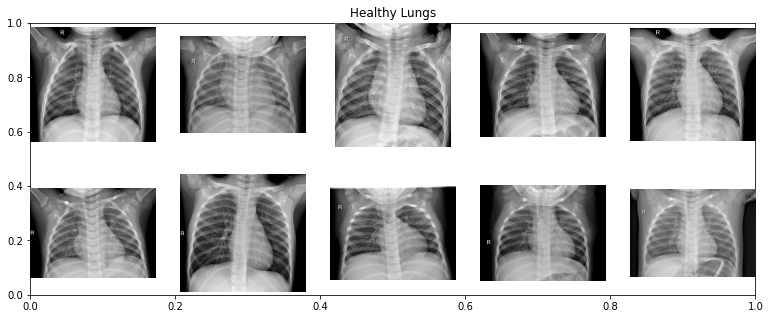

In [4]:
healthy_imgs=read_from_direct(r"corona\train\normal\*.jpeg")
image_plot(healthy_imgs,"Healthy Lungs")

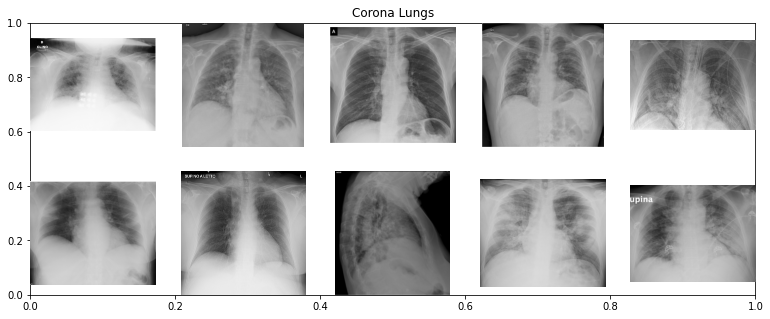

In [5]:
corona_imgs=read_from_direct(r"corona\train\corona\*.jpeg")
image_plot(corona_imgs,"Corona Lungs")

In [6]:
image_gen=ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1/255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [7]:
# CREATING THE MODEL
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(128,128,3),activation='relu')) # Convolution layer
model.add(MaxPooling2D(pool_size=(2,2))) # Pooling layer


model.add(Conv2D(filters=64,kernel_size=(4,4),input_shape=(128,128,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # Flattening layer

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.1)) # Reduces overfitting by randomly turning neurons off during training

model.add(Dense(1,activation="sigmoid")) # Output layer
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [9]:
input_shape=(128,128)
batch_size=16
train_image_gen= image_gen.flow_from_directory(r"corona\train",
                                               target_size=input_shape,
                                               batch_size=batch_size,
                                               class_mode='binary')


test_image_gen= image_gen.flow_from_directory(r"corona\test",
                                               target_size=input_shape,
                                               batch_size=batch_size,
                                               class_mode='binary')


Found 264 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [10]:
train_image_gen.class_indices # Tells what index belongs to what class

{'corona': 0, 'normal': 1}

In [16]:
results=model.fit(train_image_gen,steps_per_epoch=9,epochs=17,validation_data=test_image_gen)

Epoch 1/17
9/9 [==============================] - 11s 1s/step - loss: 0.2874 - accuracy: 0.8681 - val_loss: 0.1012 - val_accuracy: 1.0000
Epoch 2/17
9/9 [==============================] - 9s 910ms/step - loss: 0.2591 - accuracy: 0.8971 - val_loss: 0.0963 - val_accuracy: 0.9500
Epoch 3/17
9/9 [==============================] - 8s 903ms/step - loss: 0.2283 - accuracy: 0.9118 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 4/17
9/9 [==============================] - 9s 993ms/step - loss: 0.2511 - accuracy: 0.9028 - val_loss: 0.2391 - val_accuracy: 0.9500
Epoch 5/17
9/9 [==============================] - 8s 896ms/step - loss: 0.2809 - accuracy: 0.8676 - val_loss: 0.1373 - val_accuracy: 0.9500
Epoch 6/17
9/9 [==============================] - 8s 882ms/step - loss: 0.3207 - accuracy: 0.8472 - val_loss: 0.1414 - val_accuracy: 0.9500
Epoch 7/17
9/9 [==============================] - 9s 954ms/step - loss: 0.3096 - accuracy: 0.8824 - val_loss: 0.2112 - val_accuracy: 0.9500
Epoch 8/17
9/9 [======

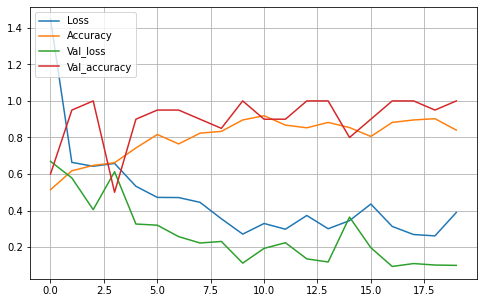

In [12]:
# VISUALIZATION
fig=plt.figure(figsize=(8,5))
lossdata=pd.DataFrame(model.history.history)
plt.plot(lossdata)
plt.legend(loc="upper left",labels=["Loss","Accuracy","Val_loss","Val_accuracy"])
plt.grid()
plt.show()


In [13]:
# PREDICTION
def prediction(directory):
    get_img=(directory)
    resize_img=load_img(get_img,target_size=(128,128)) # loading image in the size of target_size
    lung_img=np.expand_dims(resize_img,axis=0) # expanding dimension
    lung_img=lung_img/lung_img.max() # Normalizing
    prediction=(model.predict(lung_img) > 0.5).astype("int32")
    plt.imshow(cv2.imread(get_img))
    print(f"0 For corona, 1 for healthy lung.\nThe prediction for the picture below is:{prediction}")   

1/1 [==============================] - 0s 276ms/step
0 For corona, 1 for healthy lung.
The prediction for the picture below is:[[1]]


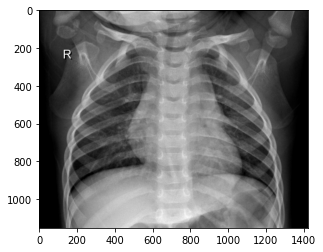

In [14]:
prediction(r"corona\test\normal\IM-0117-0001.jpeg")

1/1 [==============================] - 0s 22ms/step
0 For corona, 1 for healthy lung.
The prediction for the picture below is:[[0]]


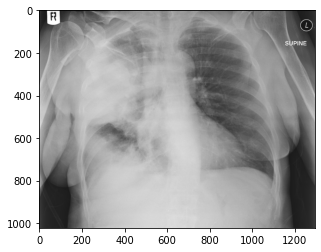

In [15]:
prediction(r"corona\test\corona\streptococcus-pneumoniae-pneumonia-1.jpg")